# Multiparticle Localization

We will build a UNet to detect and locate multiple quantum dots in fluorescence images.

## Quantum dot movie frames

We will use a few frames from a video of quantum dots labeling a membrane protein in the membrane of living cells.

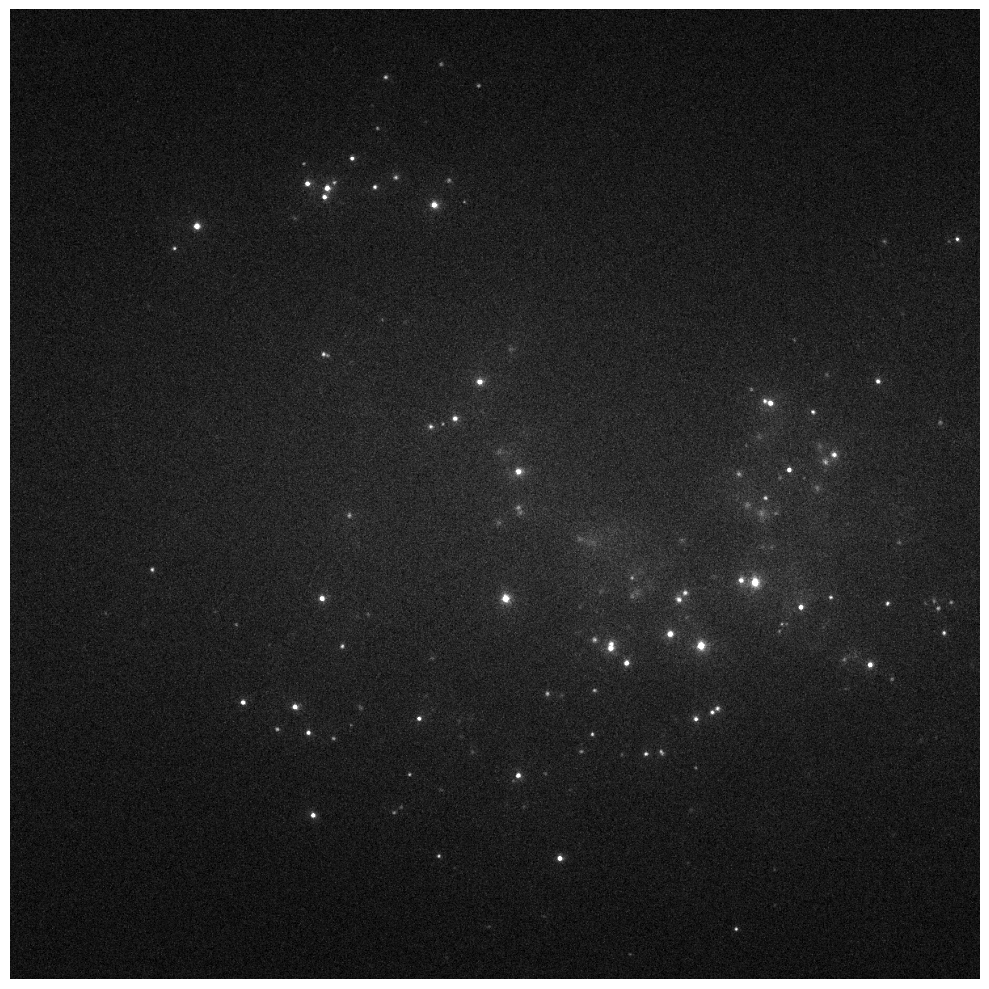

In [1]:
from PIL import Image
from matplotlib import pyplot as plt

image_of_particles = Image.open("./frame_0.tif")

plt.figure(figsize=(10, 10))
plt.imshow(image_of_particles, vmin=100, vmax=200, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

We'll focus on an individual quantum dot appearing in the first frame. 

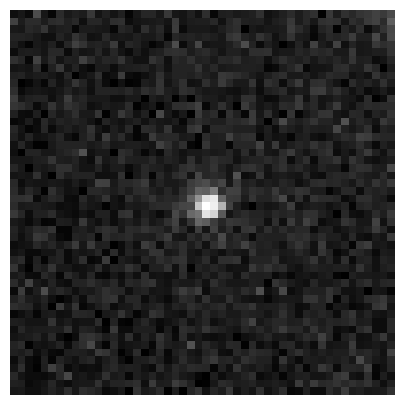

In [2]:
raw_image = Image.open("./frame_0.tif")
pos_x, pos_y, crop_size = 178, 271, 50
crop = raw_image.crop((pos_x, pos_y, pos_x + crop_size, pos_y + crop_size))

plt.figure(figsize=(5, 5))
plt.imshow(crop, cmap="gray", vmin=100, vmax=200)
plt.axis("off")
plt.show()

The quantum dots have a negligible physical size with respect to the point spread function of the microscope and can thus be simulated as point emitters using `DeepTrack`. We can tune the parameters...

In [3]:
import deeptrack as dt
import numpy as np
###from numpy.random import poisson

optics = dt.Fluorescence(
    wavelength=600 * dt.units.nm,
    NA=0.9,
    magnification=1,
    resolution=0.11 * dt.units.um,
    output_region=(0, 0, 50, 50),
)
particle = dt.PointParticle(position=(25, 25), intensity=1.2e4, z=0)
simulation_pipeline = (optics(particle) >> dt.Add(30) >> np.random.poisson 
                       >> dt.Add(80))

2024-02-02 12:56:07.921510: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


... and obtain simulations that quantitatively reproduce the experimental data, as we can see by comparing the images and their histograms.

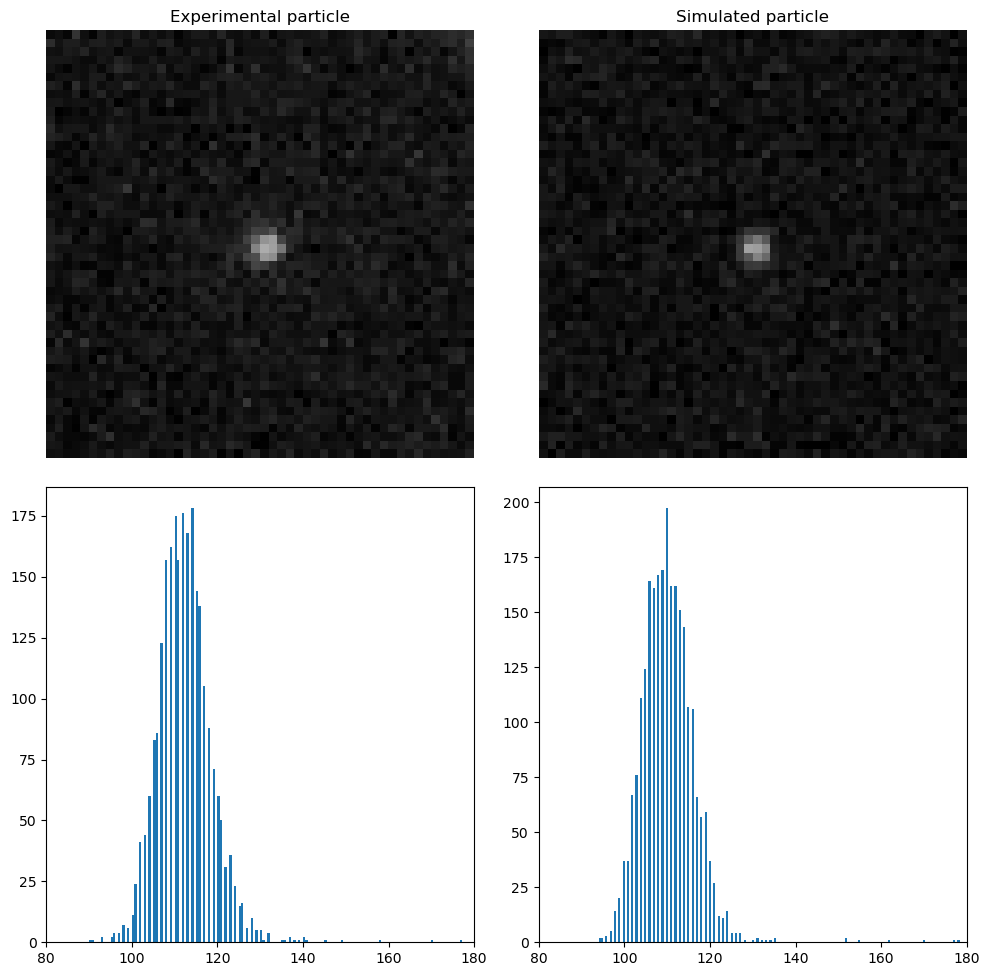

In [4]:
simulated_image = simulation_pipeline.update()()

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(crop, cmap="gray", vmin=100, vmax=250)
plt.axis("off")
plt.title("Experimental particle")

plt.subplot(2, 2, 2)
plt.imshow(simulated_image, cmap="gray", vmin=100, vmax=250)
plt.axis("off")
plt.title("Simulated particle")

plt.subplot(2, 2, 3)
plt.hist(np.array(crop).flatten(), 200)
plt.xlim([80, 180])

plt.subplot(2, 2, 4)
plt.hist(np.array(simulated_image).flatten(), 200)
plt.xlim([80, 180])

plt.tight_layout()
plt.show()

We can use these simulations parameters as a starting point to build a training dataset, in which each image contains multiple quantum dots.

In [5]:
###from numpy.random import uniform, randint
import torch

optics = dt.Fluorescence(
    NA=0.9,
    magnification=1,
    wavelength=600 * dt.units.nm,
    resolution=0.11 * dt.units.um,
    output_region=(0, 0, 128, 128),
)
particle = dt.PointParticle(
    position=lambda: np.random.uniform(0, 128, size=2),
    intensity=lambda: np.random.uniform(6e3, 3e4),
    z=lambda: np.random.uniform(-0.5, 0.5) * dt.units.um,
)
postprocess = (dt.Add(lambda: np.random.uniform(20, 40)) >> np.random.poisson 
               >> dt.Add(lambda: np.random.uniform(70, 90)))
normalization = dt.AsType("float") >> dt.Subtract(110) >> dt.Divide(250)

sample = particle ^ (lambda: np.random.randint(10, 20))
simulation_pipeline = optics(sample) >> postprocess >> normalization

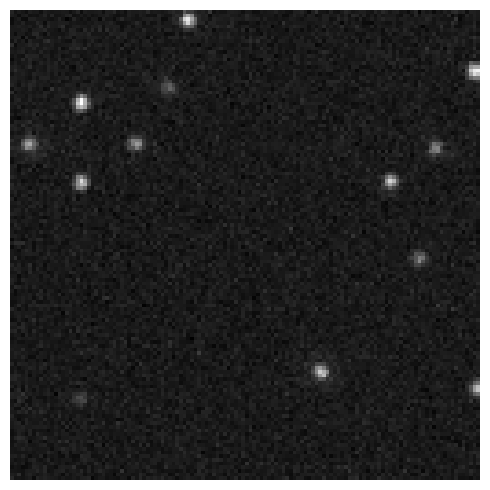

In [6]:
image = simulation_pipeline.update()()

plt.figure(figsize=(5, 5))
plt.imshow(image.squeeze(), cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

As a target, we will use a binary map of the quantum dots locations.

In [7]:
###from numpy import concatenate

def map_classes(image):
    """Map classes."""
    image = image.copy()
    im_out = np.concatenate((abs(1 - image), image), axis=-1)
    return im_out


gt_masks = (
    sample
    >> dt.SampleToMasks(
        lambda: lambda particle: particle > 0,
        output_region=optics.output_region,
        merge_method="or",
    )
    # >> dt.Multiply(100)
    >> map_classes
)

So that we can get image/map pairs through a pipeline.

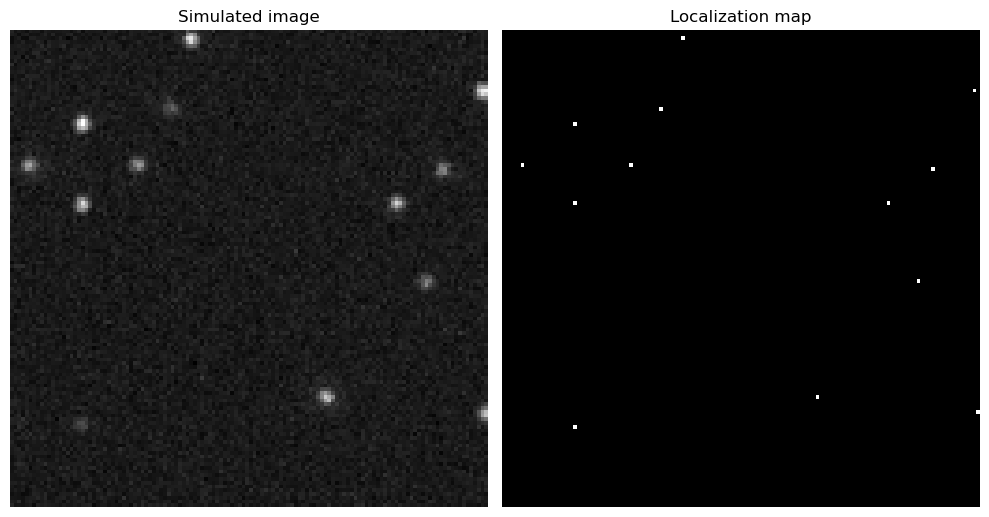

In [8]:
image_mask_pipeline = (
    (simulation_pipeline & gt_masks)
    >> dt.MoveAxis(2, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float)
)

simulated_image, gt_image = image_mask_pipeline()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(simulated_image.squeeze(), cmap="gray")
plt.axis("off")
plt.title("Simulated image")
plt.subplot(1, 2, 2)
plt.imshow(gt_image.squeeze()[1], cmap="gray")
plt.axis("off")
plt.title("Localization map")
plt.tight_layout()
plt.show()

## UNet

We implement a shallow UNet since the problem does not require a large receptive field.

In [9]:
import deeplay as dl
###from torch.nn import Softmax, Sigmoid, Identity

unet = dl.UNet2d(in_channels=1, channels=[16, 32, 64], out_channels=2)

print(unet)

UNet2d(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Layer[Identity]()
        (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=16)
      )
      (1): PoolLayerActivationNormalization(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=32)
      )
      (2): PoolLayerActivationNormalization(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=64)
      )
      (3): PoolLayerActivationNormalization(
        (pool):

Since the ground truth is mostly composed by zeros, we need to avoid that the loss force the network to just predict zeros, regardless of the input.
We achieve that with use a biased crossentropy loss, which punishes false negatives more harshly than false positives.

In [10]:
###import torchmetrics as tm
from torch.nn import CrossEntropyLoss

unet_regressor = dl.Regressor(
    model=unet,
    loss=CrossEntropyLoss(weight=torch.tensor([1, 10])),  # BCELoss(),  #
    optimizer=dl.Adam(),
).create()

We train it over 320 images, with a 10% probability to be replaced at each iteration, for 50 epochs. 

In [11]:
from torch.utils.data import DataLoader

train_dataset = dt.pytorch.Dataset(image_mask_pipeline, length=320, replace=0.1)
data_loader = DataLoader(train_dataset, batch_size=32)
unet_trainer = dl.Trainer(max_epochs=50, accelerator="auto")

unet_trainer.fit(unet_regressor, data_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
INFO: 
  | Name          | Type             | Params

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


We test the results over the first frame of the quantum dots movie. 

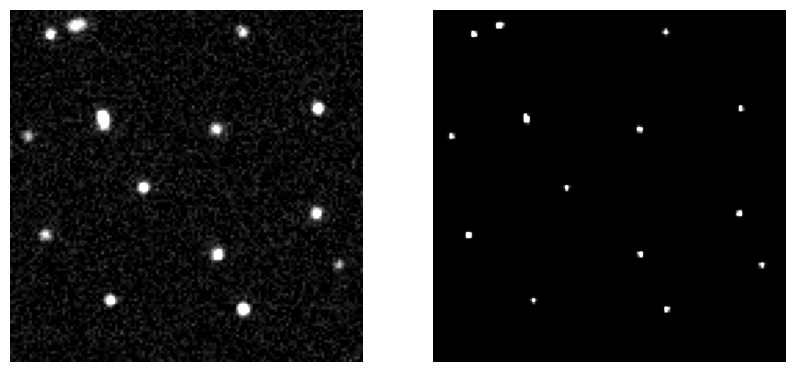

In [12]:
from torch.nn import LogSoftmax

raw_image, _ = image_mask_pipeline.update()()
raw_image = raw_image.unsqueeze(0)

pred = unet_regressor(raw_image).detach()
pred = torch.nn.functional.softmax(pred, dim=1)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(raw_image.squeeze(), vmin=0, vmax=0.3, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pred.squeeze()[1], vmin=0, vmax=0.5, cmap="gray")
plt.axis("off")

plt.show()

In [13]:
###from numpy import array
from skimage.measure import label, regionprops
from scipy.spatial import distance_matrix
from scipy.optimize import linear_sum_assignment


### This mask_to_positions() converts a binary mask into an array of centroid positions corresponding to each labeled region within the mask. 
def mask_to_positions(mask):
    """Convert binary mask to centroid array."""
    labels = label(mask)                                                        # Label connected components in the mask.
    props = regionprops(labels)                                                 # Calculate properties of labeled regions.
    return np.array([prop.centroid for prop in props])

"""
    Match predicted positions with true positions based on their proximity.
    
    This function finds the best match between predicted positions and true positions 
    such that the distance between a predicted position and its matched true position 
    is minimized. Matches where the distance exceeds a specified maximum distance are excluded.
    
    Parameters:
    - predicted_positions (np.ndarray): An array of shape [n, 2] representing the predicted positions, 
                                        where 'n' is the number of predictions and each position 
                                        is given by (x, y) coordinates.
    - true_positions (np.ndarray): An array of shape [m, 2] representing the true positions,
                                   where 'm' is the number of true positions and each position
                                   is given by (x, y) coordinates.
    - max_distance (float, optional): The maximum allowed distance between a predicted position 
                                      and its matched true position for the match to be considered valid. 
                                      Defaults to 2.
    
    Returns:
    - tuple of two arrays: (row_indices, col_indices), where 'row_indices' are the indices of the 
                            predicted positions that have been successfully matched with a true position,
                            and 'col_indices' are the corresponding indices of the true positions to which 
                            they are matched. The length of these arrays, 'k', is the number of successful matches.
    
    Note:
    - This function uses a distance matrix to compute pairwise distances between predicted and true positions,
      and the Hungarian algorithm (linear_sum_assignment) to find the optimal matching based on these distances.
    - Matches where the distance between the predicted position and the true position exceeds 'max_distance' 
      are filtered out and not included in the output.
"""
def match_positions(predicted_positions, true_positions, max_distance=2):       # predicted_positions: [n, 2] # true_positions: [m, 2] # return: (k,) (k,), where k is the number of matches
    """Match predicted and true positions."""
    if len(predicted_positions) == 0 or len(true_positions) == 0:
        return [], []                                                           # Return empty lists if either input list is empty
    d_matrix = distance_matrix(predicted_positions, true_positions)             # Compute the distance matrix between each predicted position and each true position
    row_indices, col_indices = linear_sum_assignment(d_matrix)                  # Use the Hungarian algorithm to find the optimal assignment between predicted and true positions
    too_far = d_matrix[row_indices, col_indices] > max_distance                 # Filter out matches where the distance exceeds the maximum allowed distance
    return row_indices[~too_far], col_indices[~too_far]

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/matplotlib/contour.py:1471: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y = np.asarray(y, dtype=np.float64)


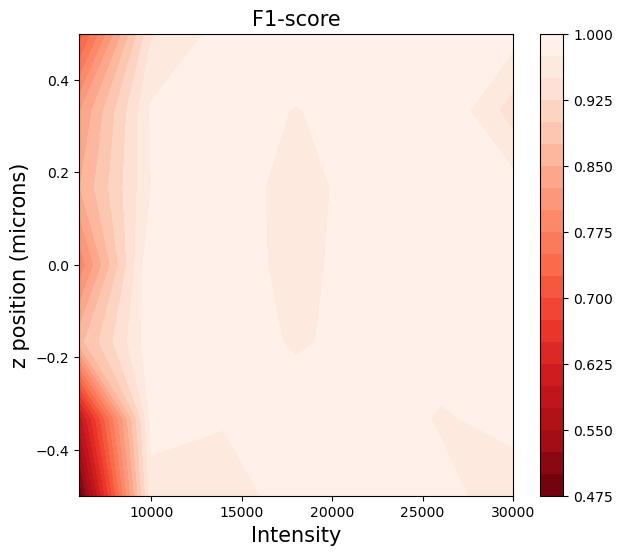

In [14]:
bins, images_per_bin = 7, 5
z_range = np.linspace(-0.5, 0.5, bins) * dt.units.um
intensity_range = np.linspace(6e3, 3e4, bins)

TP, FP, FN = [np.zeros((bins, bins)) for _ in range(3)]
for z_index, z in enumerate(z_range):
    for intensity_index, intensity in enumerate(intensity_range):
        for image_index in range(images_per_bin):
            print(f"Image {image_index} z={z:.2f} I={intensity}", end="\r")
    
            # Generate image
            image_mask_pipeline.update()
            image, gt_mask = image_mask_pipeline(z=z, intensity=intensity)
        
            # Predict mask
            pred_mask = unet_regressor(image.unsqueeze(0)).detach()
            pred_mask = torch.nn.functional.softmax(pred_mask, dim=1)
            
            # Compute metrics
            gt_positions = mask_to_positions(gt_mask[1, ...] > 0.5)
            pred_positions = mask_to_positions(pred_mask[0, 1, ...] > 0.5)
            row_indices, _ = match_positions(pred_positions, gt_positions)
            num_matches = len(row_indices)
            TP[z_index, intensity_index] += num_matches
            FP[z_index, intensity_index] += len(pred_positions) - num_matches
            FN[z_index, intensity_index] += len(gt_positions) - num_matches

F1 = 2 * TP / (2 * TP + FP + FN)

plt.figure(figsize=(7, 6))
plt.contourf(intensity_range, z_range, F1, levels=20, cmap="Reds_r")
plt.colorbar()
plt.title("F1-score", fontsize=15)
plt.xlabel("Intensity", fontsize=15)
plt.ylabel("z position (microns)", fontsize=15)
plt.show()
    

In [15]:
image_of_particles_tensor = torch.from_numpy(
    (np.array(image_of_particles).astype(np.float32) - 110) / 250
).unsqueeze(0)

pred_mask = unet_regressor(image_of_particles_tensor.unsqueeze(0)).detach()
pred_mask = torch.nn.functional.softmax(pred_mask, dim=1)
positions = mask_to_positions(predicted_mask[0, 1, ...] > 0.5)

plt.figure(figsize=(10, 10))
plt.imshow(image_of_particles, vmin=100, vmax=200, cmap="gray")
plt.scatter(positions[:, 1], positions[:, 0], 100, facecolors="none",
            edgecolors=(0.0039, 0.45, 0.70))
plt.axis("off")
plt.tight_layout()
plt.show()

NameError: name 'predicted_mask' is not defined